AI - TP3_8

Bastien SAUVAT et Bastien FAISANT

# Exercise 3 : Mini-project : Image to text description (2)

## Part 2: Fine tuning pre-trained model on food dataset

In [1]:
from datasets import load_dataset
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration, pipeline
import json
import os

### Load data from csv file

In [2]:
# Load data from csv file
csv_file_path = "./kaggle/input/FoodImages/dataset/food_dataset.csv"
image_folder_path = "./kaggle/input/FoodImages/images"
root = "./kaggle/input/FoodImages/"

In [3]:
data = load_dataset("./kaggle/input/FoodImages/dataset/", split="train")

In [4]:
data

Dataset({
    features: ['Unnamed: 0', 'Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients'],
    num_rows: 13501
})

#### Create JSONL file with image and text information

In [5]:
# Créer un fichier JSONL contenant les informations sur les images et les textes
captions = []
for idx, row in enumerate(data):
    if(row["Image_Name"] == "#NAME?"):
        continue
    caption = {"file_name": row["Image_Name"] + ".jpg", "text": row["Title"]}
    captions.append(caption)

### Fine tuning model

In [7]:
training_captions = captions[:1000]


In [8]:
len(training_captions)

1000

In [9]:
training_captions[0]

{'file_name': 'miso-butter-roast-chicken-acorn-squash-panzanella.jpg',
 'text': 'Miso-Butter Roast Chicken With Acorn Squash Panzanella'}

#### Create a custom dataset for loading images and texts

In [10]:
class CustomDataset(Dataset):
    def __init__(self, texts, image_folder, processor):
        self.texts = texts
        self.image_folder = image_folder
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.texts[idx]['file_name'])
        image = Image.open(img_name).convert('RGB')
        text = self.texts[idx]['text']

        encoding = self.processor(images=image, text=text, padding="max_length", return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

#### Load pre-trained processor and model

In [11]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [12]:
batch_size = 4
epochs = 3

In [13]:
# Create an instance of the custom dataset
train_dataset = CustomDataset(training_captions, image_folder_path, processor)

# Use DataLoader to load data in batches
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [14]:
len(train_dataset)

1000

In [15]:
len(train_dataloader)

250

#### Initialize optimizer, move model to GPU if available and training loop

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.185712814331055
Loss: 10.288263320922852
Loss: 10.248907089233398
Loss: 10.288721084594727
Loss: 10.197474479675293
Loss: 10.234495162963867
Loss: 10.190726280212402
Loss: 10.196008682250977
Loss: 10.186097145080566
Loss: 10.17470645904541
Loss: 10.164237976074219
Loss: 10.142898559570312
Loss: 10.101713180541992
Loss: 9.750356674194336
Loss: 9.12031078338623
Loss: 8.831013679504395
Loss: 8.61776065826416
Loss: 8.446491241455078
Loss: 8.25987720489502
Loss: 8.087995529174805
Loss: 7.94931173324585
Loss: 7.816455841064453
Loss: 7.695065975189209
Loss: 7.511808395385742
Loss: 7.395037651062012
Loss: 7.2703537940979
Loss: 7.116857528686523
Loss: 7.017887115478516
Loss: 6.885563373565674
Loss: 6.742624759674072
Loss: 6.6238908767700195
Loss: 6.478815078735352
Loss: 6.350039482116699
Loss: 6.207513332366943
Loss: 6.089659214019775
Loss: 5.9629807472229
Loss: 5.809409141540527
Loss: 5.686575889587402
Loss: 5.565135955810547
Loss: 5.407888412475586
Loss: 5.265885829925537
Loss: 5.139

#### Save the finetuned model

In [17]:
output_dir = "./kaggle/working/finetuned_model/"

os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)

processor.save_pretrained(output_dir)

#### Generate captions for an example image

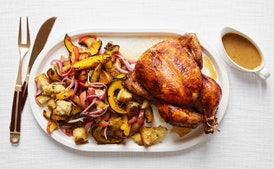

In [18]:
# Load image
img_name = os.path.join(image_folder_path, training_captions[0]['file_name'])
image = Image.open(img_name).convert('RGB')
image

In [19]:
# Prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

roast chicken with potatoes and greens


In [20]:
# Check the legend obtained with the expected one
verification_caption = training_captions[0]['text']
verification_caption

'Miso-Butter Roast Chicken With Acorn Squash Panzanella'

### Model testing

#### Load the finetuned model and processor

In [6]:
output_dir = "./kaggle/working/finetuned_model/"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the finetuned model
finetuned_model = BlipForConditionalGeneration.from_pretrained(output_dir)
finetuned_model = finetuned_model.to(device)

# Load processor
finetuned_processor = AutoProcessor.from_pretrained(output_dir)

#### Generate captions for an example image

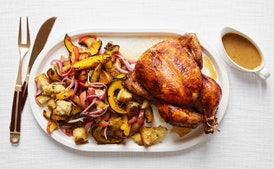

In [7]:
# Load image
img_name = os.path.join(image_folder_path, captions[0]['file_name'])
image = Image.open(img_name).convert('RGB')
image

In [8]:
# Model without fine-tuning
captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
captioner(image)

c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a plate of food with a chicken and vegetables'}]

In [9]:
# Prepare image for the fine-tuned model
inputs = finetuned_processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = finetuned_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = finetuned_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

roast chicken with potatoes and greens


In [10]:
# Check the legend obtained with the expected one
verification_caption = captions[0]['text']
verification_caption

'Miso-Butter Roast Chicken With Acorn Squash Panzanella'

#### Generate captions for another example image from the untrained dataset

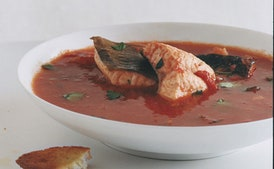

In [11]:
# Load untrained image
img_name = os.path.join(image_folder_path, captions[9972]['file_name'])
image = Image.open(img_name).convert('RGB')
image

In [12]:
captioner(image)

c:\Users\fst09\anaconda3\envs\py35env\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a bowl of soup with bread on the side'}]

In [13]:
# Prepare image for the model
inputs = finetuned_processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = finetuned_model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = finetuned_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

tomato - braised pork with ginger - braised lamb


In [14]:
# Check the legend obtained with the expected one
verification_caption = captions[9972]['text']
verification_caption

'Umbrian Fish Soup'